In [ ]:
# default_exp gbe.ist.data_provider

# IST
Here, we load the information sampling task data into a dataframe for further processing.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from fastcore.foundation import patch
from trr265.gbe.data_provider import GBEProvider
from trr265.data_provider import get_efficiently
import numpy as np
import os
import pandas as pd

## Getting the data

In [ ]:
#export
class ISTDataProvider(GBEProvider):
    '''This class builds upon GBEProvider to get the working memory task data.'''
    def __init__(self, data_folder_path):
        GBEProvider.__init__(self, data_folder_path)

In [ ]:
dp = ISTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')

### Parsing output strings

In [ ]:
def decode_cg_strings(df):
    column = "CardGame"
    '''Turning df into trial-level df based on GBE strings.
    '''
    gbe_data = pd.concat(df.set_index(['participant','baseline_session'])[column].apply(decode_cg_string).values, keys = df.index)
    gbe_data.index.rename('trial_index',level = 1, inplace = True)
    df = pd.merge(left=df, right=gbe_data.reset_index(level=1), left_index = True, right_index = True).reset_index()
    df['trial_index'] = df.trial_index + 1 # Making the trial index one-based
    return df

def decode_cg_string(s):
    """This helper function turns gbe output strings into dataframes"""
    #def replace(g):
    #    return g.group(0).replace(',', '|')

    #s = re.sub(r'\[.*?\]', replace, s)
    #columns, df = s.replace('","',';').replace('"','').split('\n')
    #df = pd.DataFrame([column.split(',') for column in df.split(';')][:-1]).transpose().ffill().iloc[:-1]
    #df.columns = [c.replace('tr_','') for c in columns.split(',')[:-1]]
    # Changing variable types
    #if 'appversion' in df.columns:
    #    df['timestarted'] = pd.to_datetime(df.timestarted.str[1:-5])
    #    df['timesubmitted'] = pd.to_datetime(df.timesubmitted.str[1:-5])
    #    if 'cardlist' in df.columns:
    #        float_columns = ['decisiontime','guesstime','secondcard','success','trialtype']
    #        df[float_columns] = df[float_columns].astype(float)
    #    else:
    #        df[df.columns[5:]] = df[df.columns[5:]].astype(float)
    #
    #else:
    #    df[['appversion','timestarted','timesubmitted','score']] = pd.Series([np.nan,np.nan,np.nan,np.nan])
    #    df = df.astype(float)
    df['first_card'] = df.cardlist.str.replace('[','').str.split('|').apply(lambda x: x[0]).astype(int).apply(lambda x: (x+1)%10)
    df['information_value'] = abs(df.first_card - 5.5)
    back_to_list = lambda x: x.strip('[]').replace('|',',').split(',')
    df['cardlist'] = df.cardlist.apply(back_to_list)
    df['movelist'] = df.movelist.apply(back_to_list)
    df['turntime'] = df.turntime.apply(back_to_list)
    df['deck_id'] = df.cardlist.apply(lambda x: ''.join([str((int(c)-1)%10) for c in x]))
    df['turns'] = df.turntime.apply(lambda x: len(x))

    return df
    
    
def get_cg_data(df):
    df = decode_cg_strings(df)
    with open('opt_string.txt','r') as f: # This file is produced based on infotask_dyprog_AA_trials.m from Hunt
        optimal_turns = f.read()
    # Getting optimal turns from Hunt's model
    ot = optimal_turns.split('\n')
    ot = [x.split(':') for x in ot][:-1]
    ot = [[list(eval(x[0])),int(x[1])] for x in ot]
    ot = pd.DataFrame(ot)
    ot.columns = ['card_values','optimal_turns']
    ot['deck_id'] = ot.card_values.apply(lambda x: ''.join([str(y-1) for y in x]))
    df = df.merge(ot[['deck_id','optimal_turns']], on='deck_id',validate='many_to_one').sort_values(by=['participant','baseline_session']).reset_index(drop = True)
    df['oversampling'] = df.turns - df.optimal_turns
    cg_vars = ["timestarted", "timesubmitted", "guesstime", "secondcard", "success", "is_even", "trialtype", "cardlist" ,"movelist", "turntime", "deck_id",'turns','optimal_turns','oversampling']
    df = df[['mov_index','gbe_index','gbe_baseline_index','initial','trial_index','participant','baseline_session']+cg_vars]
    return df

df = get_cg_data(bs)

is_multiplicative = (df.set_index('participant')['trialtype']<2).reset_index().groupby('participant').max()
wrong_game_pps = list(is_multiplicative[is_multiplicative.trialtype].index)
print("%d participants used the wrong version of the game."%len(wrong_game_pps))
df = df[df.participant.isin(wrong_game_pps)==False]

> Here we get the optimal turns for each state based on Hunt (to recreate opt_string.txt, run "_IST Hunt Script (matlab)" with a matlab kernel).

In [ ]:
#export
@patch
def get_optimal_turns(self:ISTDataProvider):
    with open(os.path.join(self.external,'opt_string.txt'),'r') as f: # 
        optimal_turns = f.read()
    # Getting optimal turns from Hunt's model
    ot = optimal_turns.split('\n')
    ot = [x.split(':') for x in ot][:-1]
    ot = [[list(eval(x[0])),int(x[1])] for x in ot]
    ot = pd.DataFrame(ot)
    ot.columns = ['card_values','optimal_turns']
    ot['deck_id'] = ot.card_values.apply(lambda x: ''.join([str(y-1) for y in x]))
    return ot
    

In [ ]:
dp.get_optimal_turns()

,card_values,optimal_turns,deck_id
0,"[1, 1, 1, 1]",1,0000
1,"[1, 1, 1, 2]",1,0001
2,"[1, 1, 1, 3]",1,0002
3,"[1, 1, 1, 4]",1,0003
4,"[1, 1, 1, 5]",1,0004
...,...,...,...
9995,"[10, 10, 10, 6]",1,9995
9996,"[10, 10, 10, 7]",1,9996
9997,"[10, 10, 10, 8]",1,9997
9998,"[10, 10, 10, 9]",1,9998


In [ ]:
#export
@patch
def decode_ist_strings(self:ISTDataProvider, gbe_data):
    df = self.decode_gbe_strings(gbe_data, "CardGame")
    back_to_list = lambda x: x.strip('[]').replace('|',',').split(',')
    df['cardlist'] = df.cardlist.apply(back_to_list)
    df['movelist'] = df.movelist.apply(back_to_list)
    df['turntime'] = df.turntime.apply(back_to_list)
    df['deck_id'] = df.cardlist.apply(lambda x: ''.join([str((int(c)-1)%10) for c in x]))
    df['turns'] = df.turntime.apply(lambda x: len(x))
    df['first_card'] = df.deck_id.astype(str).apply(lambda x: int(x[0])+1)
    ot = self.get_optimal_turns()
    df = df.merge(ot[['deck_id','optimal_turns']], on='deck_id',validate='many_to_one').sort_values(by=['gbe_index','trial_number']).reset_index(drop = True)
    df['oversampling'] = df.turns - df.optimal_turns
    return df

In [ ]:
gbe_data = dp.get_gbe_data()
df = dp.decode_ist_strings(gbe_data.iloc[:30])
df

,gbe_index,trial_number,score,timestarted,timesubmitted,cardlist,decisiontime,guesstime,movelist,secondcard,success,trialtype,turntime,deck_id,turns,first_card,optimal_turns
0,b001_001,1,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[4, 18, 22, 5]",0.70,1.09,"[0, 1]",1,1,0,"[1.54, 1.34]",3714,2,4,3
1,b001_001,2,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[40, 32, 26, 31]",0.64,2.56,"[2, 0]",0,1,0,"[1.20, 0.89]",9150,2,10,1
2,b001_001,3,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[38, 1, 26, 9]",0.54,1.30,"[1, 2, 3]",2,1,0,"[42.03, 1.04, 0.71]",7058,3,8,4
3,b001_001,4,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[34, 27, 12, 33]",0.69,0.55,"[3, 1, 0]",1,0,0,"[1.54, 0.67, 0.50]",3612,3,4,3
4,b001_001,5,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[19, 35, 25, 17]",2.51,1.37,[0],1,1,0,[1.14],8446,1,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,b013_007,17,640,2020-09-14 17:39:19.246,2020-09-14 17:45:38.621,"[10, 37, 19, 2]",0.87,0.35,"[2, 1, 0]",1,1,3,"[1.14, 0.80, 1.59]",9681,3,10,1
605,b013_007,18,640,2020-09-14 17:39:19.246,2020-09-14 17:45:38.621,"[33, 8, 19, 28]",0.58,4.45,"[0, 3]",3,1,3,"[1.04, 1.74]",2787,2,3,3
606,b013_007,19,640,2020-09-14 17:39:19.246,2020-09-14 17:45:38.621,"[13, 37, 40, 1]",0.92,5.72,"[3, 1, 0]",1,0,3,"[1.17, 0.82, 1.49]",2690,3,3,3
607,b013_007,20,640,2020-09-14 17:39:19.246,2020-09-14 17:45:38.621,"[5, 25, 6, 29]",1.40,1.44,"[0, 2, 3]",2,1,3,"[1.08, 0.83, 0.87]",4458,3,5,4


### Getting the data

In [ ]:
#export
@patch
@get_efficiently
def get_ist_data(self:ISTDataProvider):
    gbe_data = self.get_gbe_data()
    df = self.decode_ist_strings(gbe_data)
    return df

In [ ]:
df = dp.get_ist_data(update = True)
df

Preparing ist_data


,gbe_index,trial_number,score,timestarted,timesubmitted,cardlist,decisiontime,guesstime,movelist,secondcard,success,trialtype,turntime,deck_id,turns,first_card,optimal_turns
0,b001_001,1,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[4, 18, 22, 5]",0.70,1.09,"[0, 1]",1,1,0,"[1.54, 1.34]",3714,2,4,3
1,b001_001,2,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[40, 32, 26, 31]",0.64,2.56,"[2, 0]",0,1,0,"[1.20, 0.89]",9150,2,10,1
2,b001_001,3,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[38, 1, 26, 9]",0.54,1.30,"[1, 2, 3]",2,1,0,"[42.03, 1.04, 0.71]",7058,3,8,4
3,b001_001,4,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[34, 27, 12, 33]",0.69,0.55,"[3, 1, 0]",1,0,0,"[1.54, 0.67, 0.50]",3612,3,4,3
4,b001_001,5,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,"[19, 35, 25, 17]",2.51,1.37,[0],1,1,0,[1.14],8446,1,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54448,m271_010,17,690,2021-07-21 10:35:58.645,2021-07-21 10:41:11.977,"[21, 2, 4, 33]",0.76,-1.00,"[3, 1, 2, 0]",1,1,3,"[1.05, 3.19, 1.45, 1.67]",0132,4,1,1
54449,m271_010,18,690,2021-07-21 10:35:58.645,2021-07-21 10:41:11.977,"[32, 23, 25, 22]",0.81,0.73,[0],3,1,3,[1.00],1241,1,2,1
54450,m271_010,19,690,2021-07-21 10:35:58.645,2021-07-21 10:41:11.977,"[10, 2, 23, 40]",0.61,-1.00,"[0, 1, 3, 2]",1,1,3,"[0.92, 3.55, 0.58, 0.48]",9129,4,10,1
54451,m271_010,20,690,2021-07-21 10:35:58.645,2021-07-21 10:41:11.977,"[8, 4, 38, 33]",0.57,-1.00,"[2, 3, 1, 0]",3,1,3,"[1.02, 0.82, 0.53, 0.45]",7372,4,8,4


## Filters

In [ ]:
#export
@patch
def filter_old_app_sessions(self:ISTDataProvider, df):
    is_multiplicative = (df.set_index('gbe_index')['trialtype'].astype(int)<2).reset_index().groupby('gbe_index').max()
    sessions_with_old_app = list(is_multiplicative[is_multiplicative.trialtype].index)
    total_sessions = len(df.gbe_index.unique())
    perc_removed = (len(sessions_with_old_app)/total_sessions)*100
    print("In %d (%.2f%%) sessions participants used an old version of the task in some of their sessions.  These sessions  were removed from the dataset."%(len(sessions_with_old_app), perc_removed))
    df = df[df.gbe_index.isin(sessions_with_old_app)==False]
    return df

In [ ]:
dp.filter_old_app_sessions(df)

In 5 (0.19%) sessions participants used an old version of the task in some of their sessions.  These sessions  were removed from the dataset.


,gbe_index,trial_number,score,timestarted,timesubmitted,cardlist,decisiontime,guesstime,movelist,secondcard,success,trialtype,turntime,deck_id,turns,first_card,optimal_turns
63,b001_004,1,380,2020-07-13 10:04:06.841,2020-07-13 10:08:58.851,"[16, 7, 40, 6]",5.78,13.34,[2],3,1,3,[0.92],5695,1,7,4
64,b001_004,2,380,2020-07-13 10:04:06.841,2020-07-13 10:08:58.851,"[37, 23, 6, 2]",3.22,0.11,"[2, 0, 3]",0,1,3,"[0.97, 1.37, 0.94]",6251,3,8,4
65,b001_004,3,380,2020-07-13 10:04:06.841,2020-07-13 10:08:58.851,"[1, 29, 27, 17]",0.55,0.82,[0],3,1,3,[0.88],0866,1,2,1
66,b001_004,4,380,2020-07-13 10:04:06.841,2020-07-13 10:08:58.851,"[24, 38, 18, 11]",1.14,0.59,"[0, 1]",1,0,3,"[0.87, 0.68]",3770,2,5,4
67,b001_004,5,380,2020-07-13 10:04:06.841,2020-07-13 10:08:58.851,"[23, 10, 36, 15]",0.80,0.22,"[0, 2]",2,0,3,"[4.88, 1.29]",2954,2,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54448,m271_010,17,690,2021-07-21 10:35:58.645,2021-07-21 10:41:11.977,"[21, 2, 4, 33]",0.76,-1.00,"[3, 1, 2, 0]",1,1,3,"[1.05, 3.19, 1.45, 1.67]",0132,4,2,1
54449,m271_010,18,690,2021-07-21 10:35:58.645,2021-07-21 10:41:11.977,"[32, 23, 25, 22]",0.81,0.73,[0],3,1,3,[1.00],1241,1,3,1
54450,m271_010,19,690,2021-07-21 10:35:58.645,2021-07-21 10:41:11.977,"[10, 2, 23, 40]",0.61,-1.00,"[0, 1, 3, 2]",1,1,3,"[0.92, 3.55, 0.58, 0.48]",9129,4,1,1
54451,m271_010,20,690,2021-07-21 10:35:58.645,2021-07-21 10:41:11.977,"[8, 4, 38, 33]",0.57,-1.00,"[2, 3, 1, 0]",3,1,3,"[1.02, 0.82, 0.53, 0.45]",7372,4,9,4


## Checks
ToDo: Add visual video check.

In [ ]:
test = dp.get_optimal_turns()

In [ ]:
test['first_card'] = test.card_values.apply(lambda x: x[0])

<AxesSubplot:xlabel='first_card', ylabel='optimal_turns'>

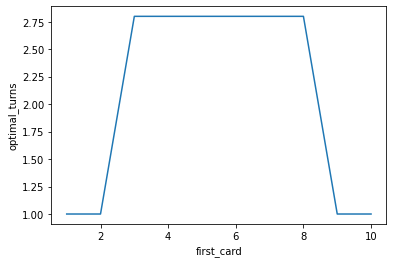

In [ ]:
sns.lineplot(x = 'first_card', y = 'optimal_turns', data = test.groupby('first_card').optimal_turns.mean().reset_index())

<AxesSubplot:>

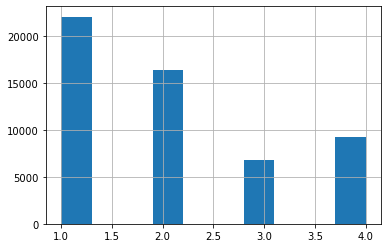

In [ ]:
df.optimal_turns.hist()

<AxesSubplot:>

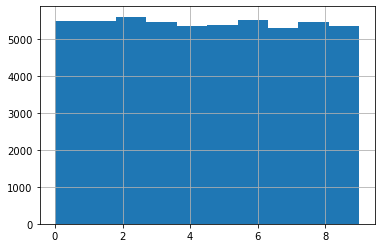

In [ ]:
df.first_card.hist()

<AxesSubplot:xlabel='first_card', ylabel='optimal_turns'>

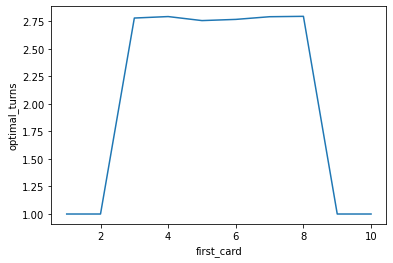

In [ ]:
import seaborn as sns
sns.lineplot(x = 'first_card', y = 'optimal_turns', data = df.groupby('first_card').optimal_turns.mean().reset_index())